# Globals

In [1]:
WORKING_ON_KAGGLE = True # True if you're working on Kaggle?
yolo_git_path = "yolov5"
PATH_WEIGHTS_YOLOV5 = "checkpoints/yolov5/best.pt" # YOLOv5 checkpoint
PATH_WEIGHTS_PDLPR = "checkpoints/pdlpr/checkpoint_epoch105.pt" # PDLPR checkpoint
archive_path_test = "dataset/dataset_test" 
extract_path = "dataset/"  #where to extract the dataset
folder = "dataset/ccpd_test"
font_path =  "C:/Windows/Fonts/msyh.ttc"
IMG_W, IMG_H = 720, 1160
BATCH_SIZE = 5
NUM_WORKERS = 0

# List of Chinese provinces 
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣",
             "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]

# List of alphabets allowed 
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N',
             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']

# alphanumeric characters for ads (license plates)
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# Combine all unique characters from provinces, alphabets, and ads, excluding the special token 'O'
unique_chars = set(provinces[:-1] + alphabets[:-1] + ads[:-1])  # 'O' excluded as special token

# Sort the unique characters alphabetically
char_list = sorted(list(unique_chars))

# Add a padding or blank character represented by "-"
char_list = ["-"] + char_list

# Create dictionaries to map characters to indices and vice versa
char2idx = {char: i for i, char in enumerate(char_list)}
idx2char = {i: c for c, i in char2idx.items()}

# Number of classes (characters + padding)
num_classes = len(char_list)
print("Num classes: ", num_classes)

Num classes:  68


# Cloning the repositories

In [2]:
repo_name = "PDLPR-algorithm"
kaggle_working_path = "/kaggle/working/"

In [3]:
if WORKING_ON_KAGGLE:
    !pip install --quiet gdown
    !apt-get install -y fonts-noto-cjk > /dev/null

    import os

    git_url = f"https://github.com/giankev/{repo_name}.git"
    os.system(f"git clone {git_url} /kaggle/working/{repo_name}")
    %cd PDLPR-algorithm/

Cloning into '/kaggle/working/PDLPR-algorithm'...


/kaggle/working/PDLPR-algorithm


In [4]:
#cloning the yolov5 repo.
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
%pip install -qr requirements.txt  #dependencies
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 25.99 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.
/kaggle/working/PDLPR-algorithm/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.1 MB/s eta 0:

# Import

In [5]:
import os
import sys
import glob
import time
import shutil
import tarfile
import warnings
import subprocess

import random
import numpy as np
import pandas as pd
import yaml

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou

from PIL import Image, ImageDraw
import cv2

from pathlib import Path

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
%matplotlib inline



# Ignore the warnings
warnings.filterwarnings("ignore")

# Custom path for PDLPR module
sys.path.append('./scr/')
from pdlpr import PDLPR

In [6]:
# Set font properties using a specific font path
if WORKING_ON_KAGGLE:
    kaggle_path = os.path.join(kaggle_working_path , repo_name)
    yolo_git_path = os.path.join(kaggle_path, yolo_git_path)
    PATH_WEIGHTS_YOLOV5 = os.path.join(kaggle_path, PATH_WEIGHTS_YOLOV5)
    PATH_WEIGHTS_PDLPR = os.path.join(kaggle_path,PATH_WEIGHTS_PDLPR)
    archive_path_test = os.path.join(kaggle_path,archive_path_test)
    extract_path =  os.path.join(kaggle_path,extract_path)
    folder  = os.path.join(kaggle_path,folder)
    NUM_WORKERS = 2
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    
prop = fm.FontProperties(fname=font_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Functions

In [7]:
#extracting the metadata from each img in this format (image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number)
def decode_plate(s):
    "this method is used for decoding the plate starting from the name of .jpg file"
    idx   = list(map(int, s.split("_")))
    try:
        return provinces[idx[0]] + alphabets[idx[1]] + "".join(ads[i] for i in idx[2:])
    except Exception:
        return None

#extracting the metadata from each img in this format (image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox)
def split_bbox(bbox_str):
    "extracting x1,y1,x2,y2, ex. '283___502_511___591'  →  ['283','502','511','591']"
    tokens = []
    for seg in bbox_str.split("___"):
        tokens.extend(seg.split("_"))
    if len(tokens) == 4 and all(t.isdigit() for t in tokens):
        return map(int, tokens)
    return (None,)*4

In [8]:
# extracting the .tar archive.
def extract_tar_archive(archive_path, destination_path):

    print(f"Extracting the tar archive in:{archive_path}")
    with tarfile.open(archive_path, "r") as tar:
        tar.extractall(path=destination_path)
        
    print(f"Archive extracted in: {destination_path}")

In [9]:
def greedy_decode(logits, blank_index, idx2char):
    preds = logits.argmax(dim=2)  # (B, T)
    decoded_batch = []
    for pred in preds:
        chars = []
        prev = None
        for p in pred:
            p = p.item()
            if p != blank_index and p != prev:
                chars.append(idx2char[p])
            prev = p
        decoded_batch.append(''.join(chars))
    return decoded_batch

In [10]:
def compute_iou(row):
    if pd.isnull(row["x1_pred"]):
        return 0.0  # No prediction

    xA = max(row["x1_true"], row["x1_pred"])
    yA = max(row["y1_true"], row["y1_pred"])
    xB = min(row["x2_true"], row["x2_pred"])
    yB = min(row["y2_true"], row["y2_pred"])

    inter_area = max(0, xB - xA) * max(0, yB - yA)

    box_true_area = (row["x2_true"] - row["x1_true"]) * (row["y2_true"] - row["y1_true"])
    box_pred_area = (row["x2_pred"] - row["x1_pred"]) * (row["y2_pred"] - row["y1_pred"])

    union_area = box_true_area + box_pred_area - inter_area

    if union_area == 0:
        return 0.0
    return inter_area / union_area

In [11]:
def collate_fn(batch):
    """Function to handle batches of images and metadata."""
    # Extract the images from the batch
    images = [item[0] for item in batch]   
    # Extract the associated metadata from the batch
    metadata = [item[1] for item in batch] 
    return images, metadata

# Dataset

In [12]:
#download the test datatset(1k for each subdataset, total 8k).
!mkdir -p dataset
!gdown --fuzzy https://drive.google.com/file/d/1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X/view?usp=drive_link -O dataset/dataset_test

Downloading...
From (original): https://drive.google.com/uc?id=1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X
From (redirected): https://drive.google.com/uc?id=1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X&confirm=t&uuid=9aba1015-388f-46d5-b4fe-b022e863c024
To: /kaggle/working/PDLPR-algorithm/dataset/dataset_test
100%|█████████████████████████████████████████| 557M/557M [00:03<00:00, 153MB/s]


In [13]:
extract_tar_archive(archive_path_test, extract_path)

Extracting the tar archive in:/kaggle/working/PDLPR-algorithm/dataset/dataset_test
Archive extracted in: /kaggle/working/PDLPR-algorithm/dataset/


In [14]:
rows = []
for root, _, files in os.walk(folder):
    for fname in sorted(files):  # Sort files for consistency
        if not fname.lower().endswith(".jpg"):
            continue  # Skip non-JPG files

        parts = fname[:-4].split("-")  # Split filename (without extension) by '-'
        if len(parts) < 6:
            continue  # Skip files with unexpected filename format

        # Extract data from the filename
        try:
            x1, y1, x2, y2 = split_bbox(parts[2])  # Parse bounding box coordinates
            plate = decode_plate(parts[4])         # Decode license plate string
            full_path = os.path.join(root, fname)  # Full path to image file

            rows.append({
                "image_path": full_path,
                "x1_true": x1, "y1_true": y1, "x2_true": x2, "y2_true": y2,
                "plate_true": plate,
                "root": root
            })
        except (ValueError, IndexError):
            print(f"Skipping malformed filename: {fname}") 
            continue

df_truth = pd.DataFrame(rows)
print(f"Ground truth DataFrame created: {len(df_truth)} rows")


Ground truth DataFrame created: 8000 rows


# Models

## YOLOv5

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_yolo = torch.hub.load(
    yolo_git_path,
    "custom",
    path=PATH_WEIGHTS_YOLOV5,
    source="local"
).to(device)

model_yolo.eval()

print("YOLOv5 loaded.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


YOLOv5 loaded.


## PDLPR

In [16]:
class LicensePlateDataset(Dataset):
    """Dataset that loads images and their associated info from a DataFrame."""
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row data
        row = self.df.iloc[idx]
        image_path = row["image_path"]
        
        # Open the image and convert to RGB
        image = Image.open(image_path).convert("RGB")
        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Return the image and its metadata as a dict
        return image, row.to_dict()


# Transformations for the License Plate Recognition (LPR) model
lpr_transform = transforms.Compose([
    transforms.Resize((48, 144)),
    transforms.ToTensor(),
])


In [17]:
# Download of checkpoints
!pip install -q gdown
import gdown

file_id = "19wevTLaCCklKl9x52NgXgvHfRpzfR1yr"
os.makedirs(os.path.dirname(PATH_WEIGHTS_PDLPR), exist_ok=True)
gdown.download(f"https://drive.google.com/uc?id={file_id}", PATH_WEIGHTS_PDLPR, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19wevTLaCCklKl9x52NgXgvHfRpzfR1yr
From (redirected): https://drive.google.com/uc?id=19wevTLaCCklKl9x52NgXgvHfRpzfR1yr&confirm=t&uuid=7b27980f-a625-491f-80c8-bf564a961400
To: /kaggle/working/PDLPR-algorithm/checkpoints/pdlpr/checkpoint_epoch105.pt
100%|██████████| 341M/341M [00:08<00:00, 38.0MB/s] 


'/kaggle/working/PDLPR-algorithm/checkpoints/pdlpr/checkpoint_epoch105.pt'

In [18]:
# Instantiate the PDLPR model and move it to the target device (CPU or GPU)
model_pdlpr = PDLPR(num_classes=num_classes).to(device)

# Load the saved checkpoint weights
checkpoint = torch.load(PATH_WEIGHTS_PDLPR, map_location=device)

# Load the weights into the model
model_pdlpr.load_state_dict(checkpoint["weights"])

# Set the model to evaluation mode
model_pdlpr.eval()

print("PDLPR model loaded successfully")


PDLPR model loaded successfully


In [19]:
# Create the dataset from your DataFrame
dataset = LicensePlateDataset(df_truth)

# Create the DataLoader to load data in batches
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,      # Number of samples per batch
    shuffle=False,              # Do not shuffle data 
    num_workers=NUM_WORKERS,    # Number of subprocesses for data loading
    collate_fn=collate_fn,      # Custom collate function to handle batches
    pin_memory=True             # Speed up transfer to GPU if available
)


# Inference

In [20]:
prediction_results = []

t0 = time.time()
with torch.inference_mode():
    for images_pil, metadatas in tqdm(dataloader, desc="Processing Batches"):
        
        # Step A: Detect license plates using YOLOv5 on batch of PIL images
        model_yolo.conf = 0.0
        results_batch = model_yolo(images_pil, size=416)
        
        crops_for_pdlpr = []
        metadata_map = []  # Map predicted plates back to original metadata
        
        # Iterate over YOLO results for each image in batch
        for i, (boxes, meta) in enumerate(zip(results_batch.xyxy, metadatas)):
            
            result_row = meta.copy()  # Copy ground truth metadata
            
            if boxes.shape[0] == 0:
                # No boxes found: set preds to NaN / empty
                result_row.update({
                    "x1_pred": np.nan, "y1_pred": np.nan,
                    "x2_pred": np.nan, "y2_pred": np.nan,
                    "plate_pred": ""
                })
                prediction_results.append(result_row)
            else:
                # At least one box found, pick best one by confidence
                best_box = boxes[boxes[:, 4].argmax()]
                coords = best_box[0:4].cpu().numpy().astype(int)
                x1p, y1p, x2p, y2p = coords
                
                # Crop detected license plate from original image
                cropped_img = images_pil[i].crop((x1p, y1p, x2p, y2p))
                
                # Transform crop to feed into LPR model
                crops_for_pdlpr.append(lpr_transform(cropped_img))
                
                # Save predicted bounding box info and keep metadata reference
                result_row.update({"x1_pred": x1p, "y1_pred": y1p, "x2_pred": x2p, "y2_pred": y2p})
                metadata_map.append(result_row)
        
        # Step B: Run LPR recognition only if we have crops
        if crops_for_pdlpr:
            batch_to_process = torch.stack(crops_for_pdlpr).to(device)
            outputs = model_pdlpr(batch_to_process)
            
            # Decode LPR model outputs and assign plate predictions
            for i, output in enumerate(outputs):
                pred_lp = greedy_decode(output.unsqueeze(0), 0, idx2char)[0]
                metadata_map[i]["plate_pred"] = pred_lp
            
            # Append recognized results to final list
            prediction_results.extend(metadata_map)

t_final = time.time() - t0
fps = len(df_truth) / t_final

print(f"\nInference complete in {t_final:.2f}s, {fps:.2f} FPS")

# Create final DataFrame with true and predicted info
df_pred = pd.DataFrame(prediction_results)

# Select relevant columns
final_df = df_pred[[
    "image_path",
    "x1_true", "y1_true", "x2_true", "y2_true", "plate_true",
    "x1_pred", "y1_pred", "x2_pred", "y2_pred", "plate_pred"
]]

# Add a 'subset' column based on folder structure
final_df["subset"] = final_df["image_path"].apply(lambda p: Path(p).parts[-2])

Processing Batches:   0%|          | 0/1600 [00:00<?, ?it/s]


Inference complete in 120.90s, 66.17 FPS


# Results

In [21]:
final_df["subset"] = final_df["image_path"].apply(lambda p: Path(p).parts[-2])

final_pred = final_df
final_pred["iou"] = final_pred.apply(compute_iou, axis=1)
final_pred["correct"] = (final_pred["iou"] > 0.6) & (final_pred["plate_pred"] == final_pred["plate_true"])
accuracy_per_subset = final_pred.groupby("subset")["correct"].mean()
average_accuracy = final_pred["correct"].mean()

print(f"{'Subset':<10} {'Accuracy':>10}")
print("-" * 22)

for k, v in accuracy_per_subset.items():
    print(f"{k:<10} {v*100:>10.2f}")

print(f"\nAverage accuracy: {average_accuracy*100:.2f} %")
print(f"Average FPS: {fps:.2f}")

Subset       Accuracy
----------------------
base            99.70
blur            81.90
challenge       88.90
db              74.60
fn              88.70
rotate          94.00
tilt            89.40
weather         98.70

Average accuracy: 89.49 %
Average FPS: 66.17


# Final Plot

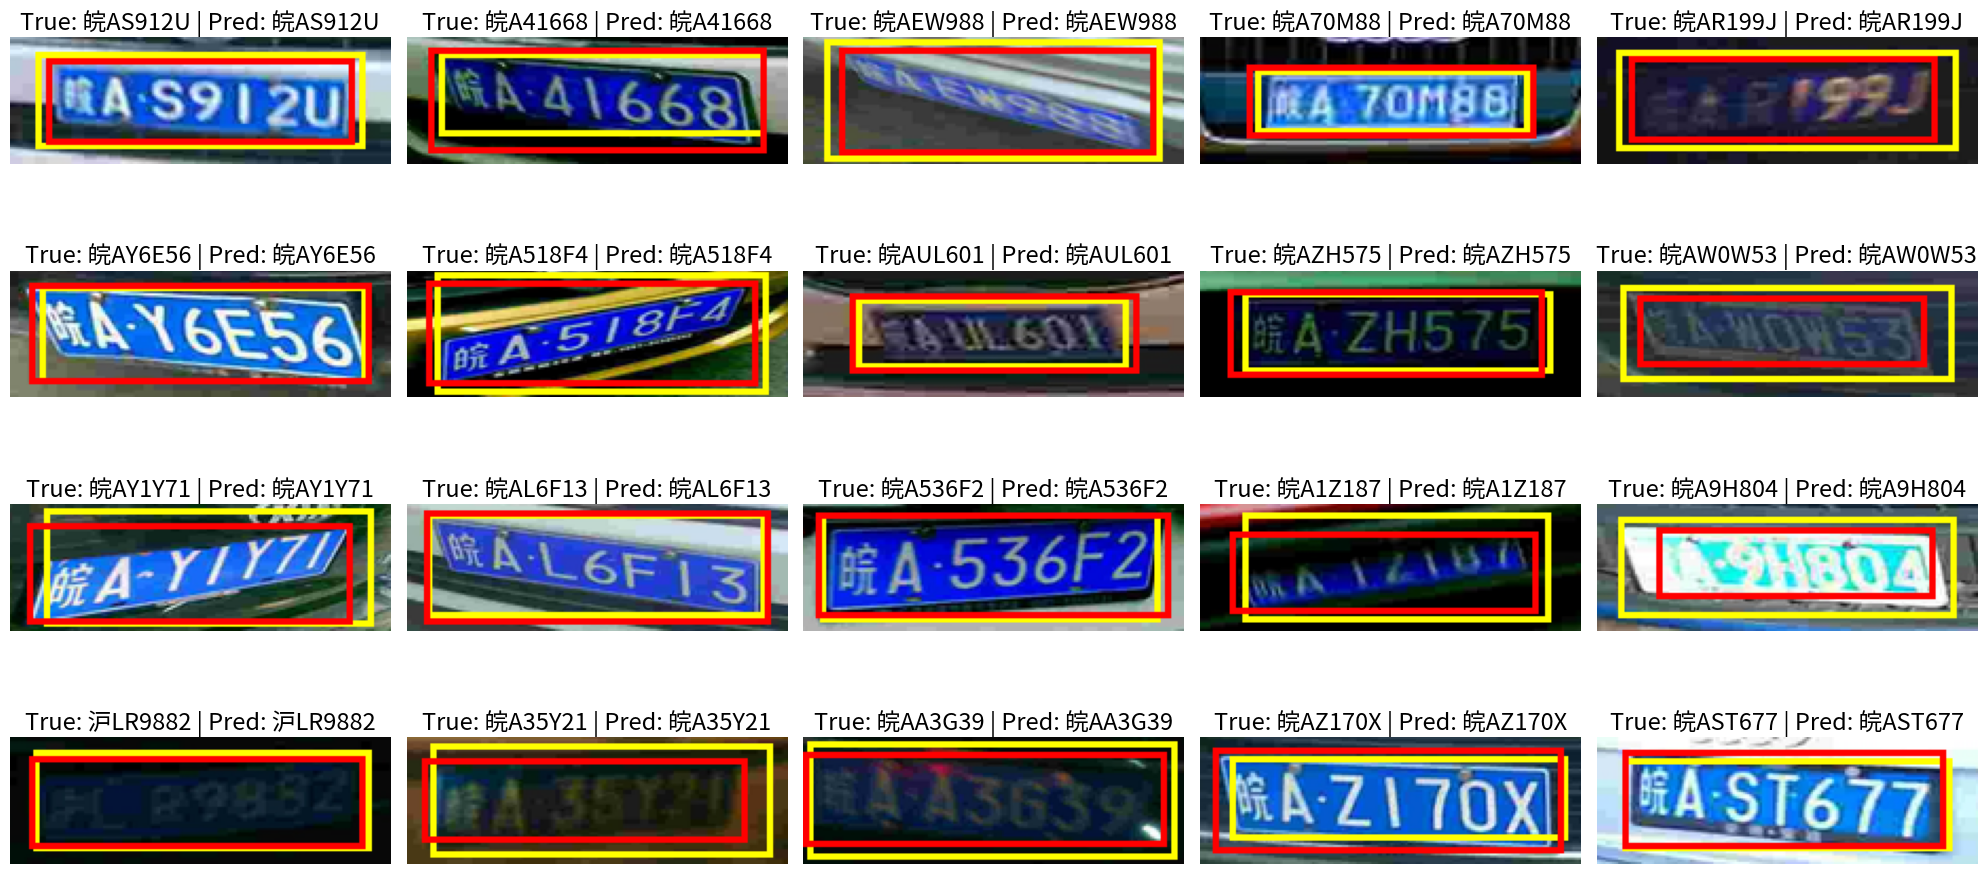

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
%matplotlib inline

# Select 20 random rows from final_df with fixed random seed for reproducibility
sample_df = final_df.sample(20, random_state=42).reset_index(drop=True)

# Create a 4x5 grid of subplots with specified figure size
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Define target height and width for resized cropped images
TARGET_H, TARGET_W = 60, 180
# Thickness of bounding box borders
BORDER_THICKNESS = 3
# Margin around bounding boxes for cropping
MARGIN = 20

for i, row in sample_df.iterrows():
    ax = axes[i]
    
    # Open image from the path stored in the dataframe row
    img = Image.open(row['image_path'])
    img_np = np.array(img)  # Convert image to numpy array for shape info

    # Extract ground truth bounding box coordinates
    x1_t, y1_t, x2_t, y2_t = row['x1_true'], row['y1_true'], row['x2_true'], row['y2_true']
    # Check if prediction coordinates are available (not NaN)
    has_pred = not pd.isna(row['x1_pred'])
    if has_pred:
        x1_p, y1_p = map(int, (row['x1_pred'], row['y1_pred']))
        x2_p, y2_p = map(int, (row['x2_pred'], row['y2_pred']))
    else:
        x1_p = y1_p = x2_p = y2_p = 0  # Dummy values if prediction not present
    
    # Collect all x and y coordinates of both true and predicted boxes (if any)
    xs = [x1_t, x2_t] + ([x1_p, x2_p] if has_pred else [])
    ys = [y1_t, y2_t] + ([y1_p, y2_p] if has_pred else [])
    
    # Calculate crop boundaries by adding margin and limiting within image dimensions
    x_min = max(min(xs) - MARGIN, 0)
    y_min = max(min(ys) - MARGIN, 0)
    x_max = min(max(xs) + MARGIN, img_np.shape[1] - 1)
    y_max = min(max(ys) + MARGIN, img_np.shape[0] - 1)
    
    # Crop the image around all bounding boxes plus margin
    cropped = img.crop((x_min, y_min, x_max, y_max))
    # Resize the cropped image to the target size
    cropped = cropped.resize((TARGET_W, TARGET_H), resample=Image.LANCZOS)
    
    # Calculate scaling factors to scale bounding boxes to resized image
    scale_x = TARGET_W / (x_max - x_min)
    scale_y = TARGET_H / (y_max - y_min)
    
    # Scale ground truth bounding box coordinates to resized image
    true_box = [
        (x1_t - x_min) * scale_x,
        (y1_t - y_min) * scale_y,
        (x2_t - x1_t) * scale_x,
        (y2_t - y1_t) * scale_y
    ]
    # Scale predicted bounding box coordinates if available
    if has_pred:
        pred_box = [
            (x1_p - x_min) * scale_x,
            (y1_p - y_min) * scale_y,
            (x2_p - x1_p) * scale_x,
            (y2_p - y1_p) * scale_y
        ]
    
    # Create a drawable image object to draw bounding boxes
    draw = ImageDraw.Draw(cropped)
    
    # Draw the ground truth bounding box in yellow with specified border thickness
    for off in range(BORDER_THICKNESS):
        draw.rectangle(
            [
                true_box[0] - off, true_box[1] - off,
                true_box[0] + true_box[2] + off, true_box[1] + true_box[3] + off
            ],
            outline="yellow"
        )
    # Draw the predicted bounding box in red if present, with the same thickness
    if has_pred:
        for off in range(BORDER_THICKNESS):
            draw.rectangle(
                [
                    pred_box[0] - off, pred_box[1] - off,
                    pred_box[0] + pred_box[2] + off, pred_box[1] + pred_box[3] + off
                ],
                outline="red"
            )

    # Show the cropped image with bounding boxes in the current subplot
    ax.imshow(cropped)
    # Set the subplot title to show true and predicted license plates with custom font
    ax.set_title(
        f"True: {row['plate_true']} | Pred: {row['plate_pred']}",
        fontdict={'fontsize': 17, 'fontproperties': prop}
    )
    ax.axis('off')  # Hide axis ticks and labels

plt.tight_layout()  # Automatically adjust subplot params for neat layout
plt.show()